In [418]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from transformers import pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import locale
locale.setlocale(locale.LC_ALL, "nl_NL")

'nl_NL'

In [325]:
df = pd.read_json('../data/political articles.json')
df.shape

(993, 36)

In [326]:
spl = pipeline(model='DTAI-KULeuven/robbert-v2-dutch-sentiment')


In [327]:
data = df['Body'].tolist()
train_data = data[:int((len(data)+1)*.80)]
test_data = data[int((len(data)+1)*.80):]

display(len(train_data), len(test_data))

795

198

In [328]:
t_data = [string[:128] + string[len(string)-384:len(string)] if len(string) > 512 else string for string in data]
display([len(string) for string in t_data][:10])
sentiments = spl(t_data)

[512, 512, 512, 512, 512, 512, 512, 512, 512, 512]

In [329]:
df = pd.concat([df, pd.DataFrame(sentiments)], axis=1)
display(df)

,Newspaper,Title,Date,Author,Section,Body,VVD,PvdA,CDA,D66,...,Volt,Henk Krol,JA21,BVNL,Belang van Nederland,van Haga,Nieuw Sociaal Contact,NSC,label,score
0,De Telegraaf,'Mona enorme kanjer'; Ex-CDA'er Keijzer premie...,2023-09-02,None,BINNENLAND,Ex-CDA'er Keijzer premierskandidaat en partij ...,1,0,7,0,...,0,0,2,0,0,0,0,1,Positive,0.998447
1,De Telegraaf,'Uitbreiding stroomnet gaat tot twee jaar in d...,2023-09-02,Theo Besteman,FINANCIEEL,Energiebedrijven vrezen door formatie te veel ...,1,0,0,0,...,0,0,0,0,0,0,0,0,Positive,0.999572
2,AD/Algemeen Dagblad,Basisbeurs magneet voor Europese student,2023-09-02,HANS VAN SOEST,Z Weekend,Migratie is een van de grootste zorgen onder k...,1,0,0,0,...,0,0,0,0,0,0,0,1,Negative,0.946431
3,Trouw,BBB laat zien dat ze vol voor het Torentje gaan,2023-09-02,BART ZUIDERVAART,Vandaag,Tweede Kamerverkiezingen Campagne Verfrissend ...,1,4,3,0,...,0,0,0,0,0,0,0,0,Positive,0.998101
4,Trouw,Bestaanszekerheid troeft migratie af als campa...,2023-09-02,NIELS MARKUS,Vandaag,Het verkiezingsprogramma dat de VVD vrijdag pr...,8,1,4,0,...,0,0,0,0,0,0,0,1,Positive,0.838114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,De Telegraaf,Brieven,2023-09-22,None,WATUZEGT,Toeslagen Fulltime werken hoeft voor veel burg...,0,0,0,0,...,0,0,0,0,0,0,0,1,Negative,0.708411
989,AD/Algemeen Dagblad,Popiejopie doen strookt niet met imago van NSC,2023-09-28,ANGELA DE JONG,Media en Cultuur,"Het was vast een scherpe, inhoudelijke vraag d...",0,0,0,0,...,0,0,0,0,0,0,0,2,Negative,0.989970
990,Trouw,lezersreacties,2023-09-29,None,Opinie,Groen noch internationaal Het is goed dat Piet...,0,0,0,0,...,0,0,0,0,0,0,0,1,Positive,0.998251
991,de Volkskrant,Soepboer,2023-09-29,SANDER DONKERS,Ten Eerste,Column: 150 Na de presentatie van de NSC-kandi...,0,0,0,0,...,0,0,0,0,0,0,0,1,Positive,0.999518


In [330]:
# lambda x: x[x["quarter"] + "_score"], axis=1

df['standardized scores'] = df.apply(lambda x: 1 - x['score'] if x['label'] == 'Negative' else x['score'], axis=1)

In [357]:
parties = ['VVD', 'CDA', 'D66', 'SGP', 'GroenLinks-PvdA', 'SP', 'CU', 'PvdD', 'PVV', '50Plus', 'DENK', 'FvD', 'Bij1', 'BBB', 'Volt', 'JA21', 'BVNL', 'NSC']

In [358]:
party_data = {}

for party in parties:
    party_data[party] = df[df[party].ge(1)]

display(party_data['VVD'][:10])

,Newspaper,Title,Date,Author,Section,Body,VVD,PvdA,CDA,D66,...,Henk Krol,JA21,BVNL,Belang van Nederland,van Haga,Nieuw Sociaal Contact,NSC,label,score,standardized scores
0,De Telegraaf,'Mona enorme kanjer'; Ex-CDA'er Keijzer premie...,2023-09-02,None,BINNENLAND,Ex-CDA'er Keijzer premierskandidaat en partij ...,1,0,7,0,...,0,2,0,0,0,0,1,Positive,0.998447,0.998447
1,De Telegraaf,'Uitbreiding stroomnet gaat tot twee jaar in d...,2023-09-02,Theo Besteman,FINANCIEEL,Energiebedrijven vrezen door formatie te veel ...,1,0,0,0,...,0,0,0,0,0,0,0,Positive,0.999572,0.999572
2,AD/Algemeen Dagblad,Basisbeurs magneet voor Europese student,2023-09-02,HANS VAN SOEST,Z Weekend,Migratie is een van de grootste zorgen onder k...,1,0,0,0,...,0,0,0,0,0,0,1,Negative,0.946431,0.053569
3,Trouw,BBB laat zien dat ze vol voor het Torentje gaan,2023-09-02,BART ZUIDERVAART,Vandaag,Tweede Kamerverkiezingen Campagne Verfrissend ...,1,4,3,0,...,0,0,0,0,0,0,0,Positive,0.998101,0.998101
4,Trouw,Bestaanszekerheid troeft migratie af als campa...,2023-09-02,NIELS MARKUS,Vandaag,Het verkiezingsprogramma dat de VVD vrijdag pr...,8,1,4,0,...,0,0,0,0,0,0,1,Positive,0.838114,0.838114
5,Trouw,"Brabantse koeienboeren krijgen extra tijd, kip...",2023-09-02,LUKAS VAN DER STORM,Nederland,Eerst was 2022 het jaar van de waarheid. Toen ...,3,2,3,2,...,0,0,0,0,0,0,0,Negative,0.999581,0.000419
6,De Telegraaf,BRIEVEN,2023-09-02,None,WATUZEGT,Accijnsverhogingen Als ik zo al die berichten ...,2,0,0,0,...,0,0,0,0,0,0,0,Positive,0.999542,0.999542
7,de Volkskrant,Coalitie wordt niet 'knetterlinks' maar 'kneit...,2023-09-02,PETER DE GRAAF,Ten Eerste,Als allerlaatste provincie en vijfenhalve maan...,5,2,0,1,...,0,0,0,0,0,0,0,Positive,0.987047,0.987047
8,de Volkskrant,De betrouwbare mannetjes waren er even helemaa...,2023-09-02,SIMON HENDRIKSEN EN MELLE RUNDERKAMP,Zaterdag,"Jongens, nu die telefoons weg. Nee. Geef maar ...",1,0,0,0,...,0,1,0,0,0,0,0,Negative,0.996742,0.003258
9,de Volkskrant,De SP wil op alle niveaus radicaal democratise...,2023-09-02,RAOUL DU PRÉ,Ten Eerste,De SP hoopt dat het einde van het tijdperk Rut...,1,0,0,0,...,0,0,0,0,0,0,1,Negative,0.999064,0.000936


In [378]:
pdf = {}
for party in parties:
    pdf[party] = party_data[party].groupby(party_data[party]['Date'])['standardized scores'].mean().reset_index()
    temp = party_data[party].groupby(party_data[party]['Date'].dt.date).size().reset_index().drop('Date', axis=1)
    # print(temp)
    pdf[party]['count'] = temp
    pdf[party] = pdf[party].set_index('Date')

display(pdf['VVD'][:10])

,standardized scores,count
Date,,
2023-09-02,0.557134,28
2023-09-04,0.730696,19
2023-09-05,0.708616,18
2023-09-06,0.627831,19
2023-09-07,0.693901,22
2023-09-08,0.632326,23
2023-09-09,0.658621,29
2023-09-11,0.662216,6
2023-09-12,0.705635,13


In [379]:
out = df.groupby(df['Date'].dt.date)['standardized scores'].mean().reset_index()
temp = df.groupby(df['Date'].dt.date)['standardized scores'].size().reset_index()
out['count'] = temp['standardized scores']
display(out[:10])

,Date,standardized scores,count
0,2023-09-02,0.564051,52
1,2023-09-04,0.718810,33
2,2023-09-05,0.714245,36
3,2023-09-06,0.713931,38
4,2023-09-07,0.638641,44
5,2023-09-08,0.694503,43
6,2023-09-09,0.738031,48
7,2023-09-11,0.550590,23
8,2023-09-12,0.676879,32
9,2023-09-13,0.616513,50


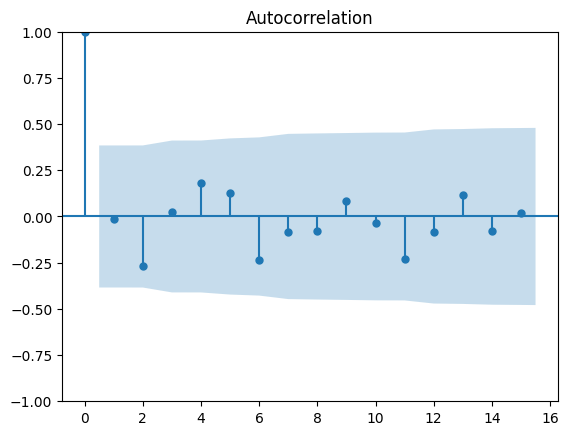

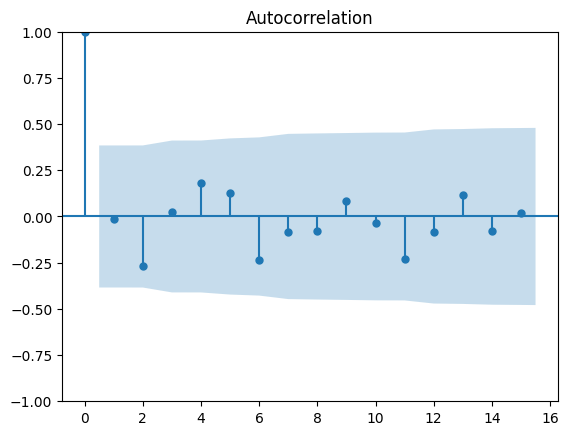

In [361]:
plot_acf(out['standardized scores'])

In [362]:

adfuller(out['standardized scores'])


(-4.177703342708877,
 0.0007185618655198685,
 1,
 24,
 {'1%': -3.7377092158564813,
  '5%': -2.9922162731481485,
  '10%': -2.635746736111111},
 -36.5638771354044)

In [363]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

In [364]:
adfuller_test(out['standardized scores'])

ADF Test Statistic : -4.177703342708877
p-value : 0.0007185618655198685
#Lags Used : 1
Number of Observations Used : 24
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


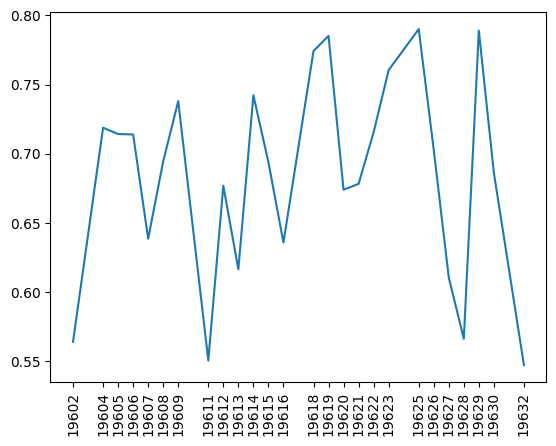

In [365]:
plt.xticks(out['Date'], rotation=90)
plt.plot(out['Date'], out['standardized scores'])

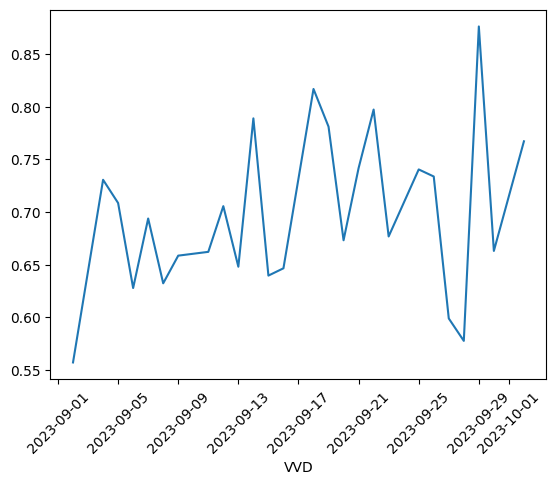

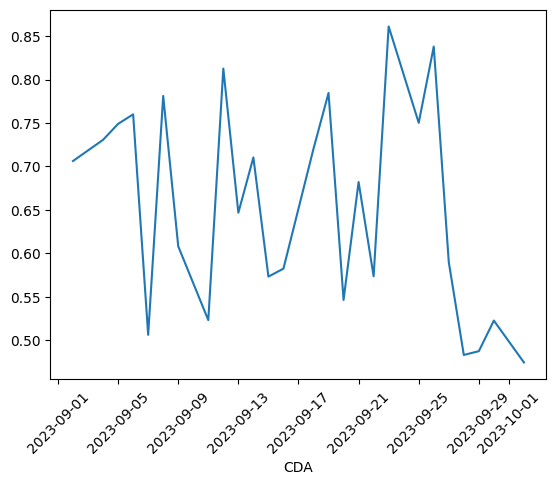

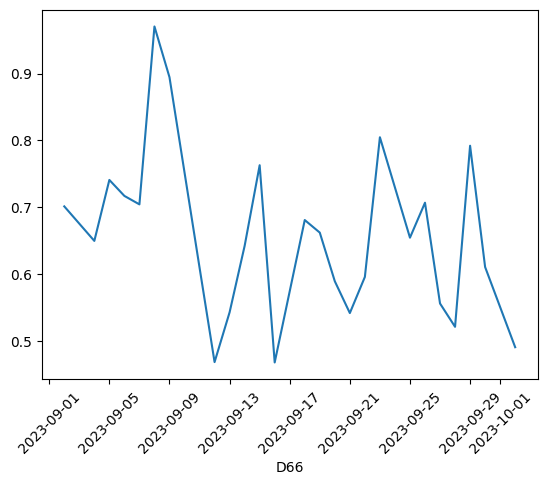

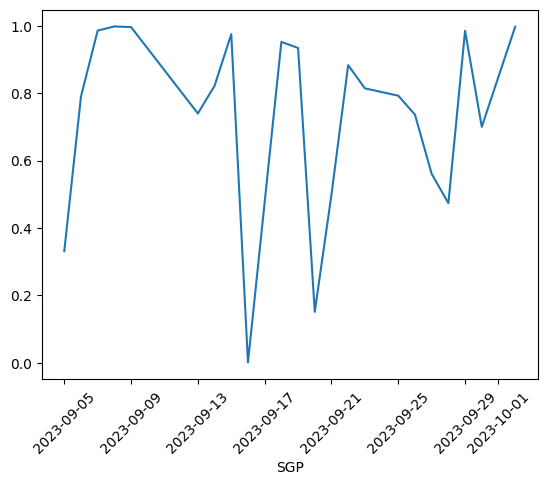

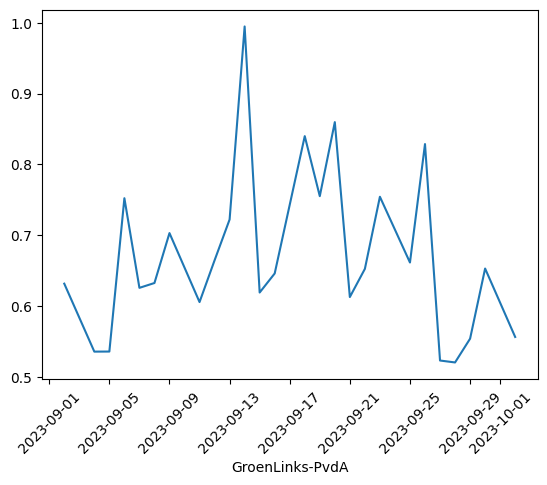

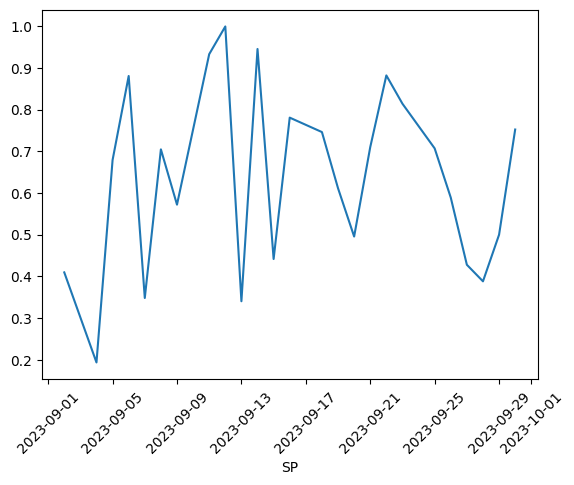

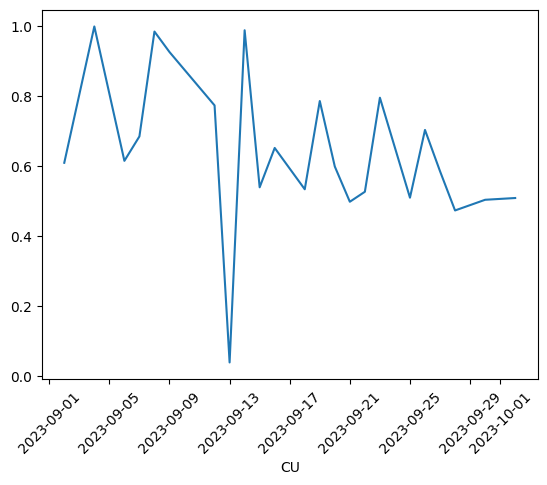

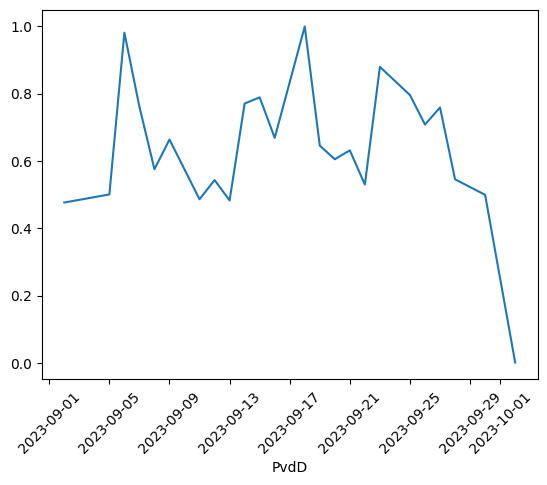

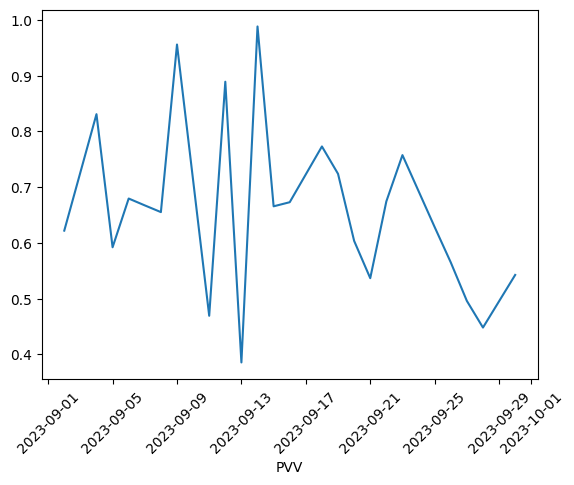

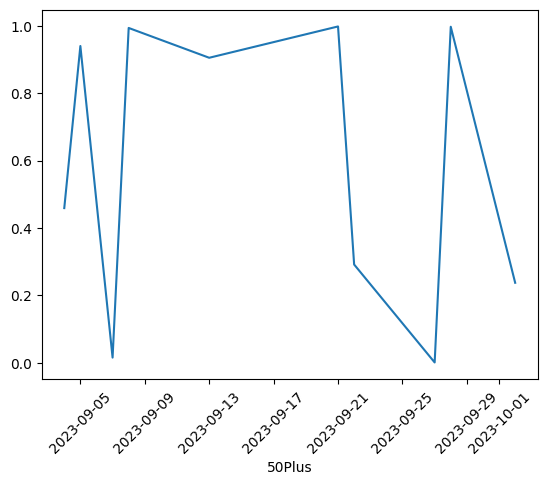

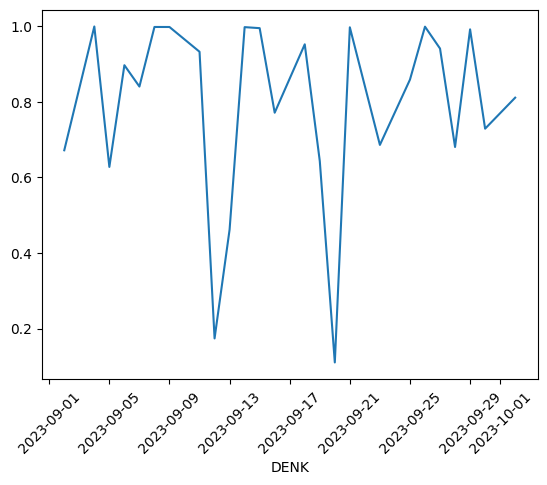

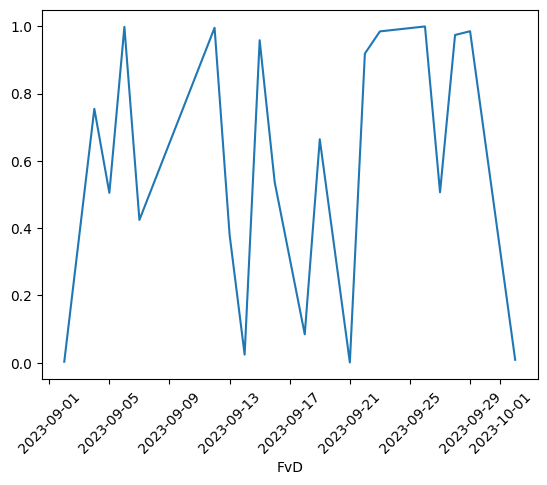

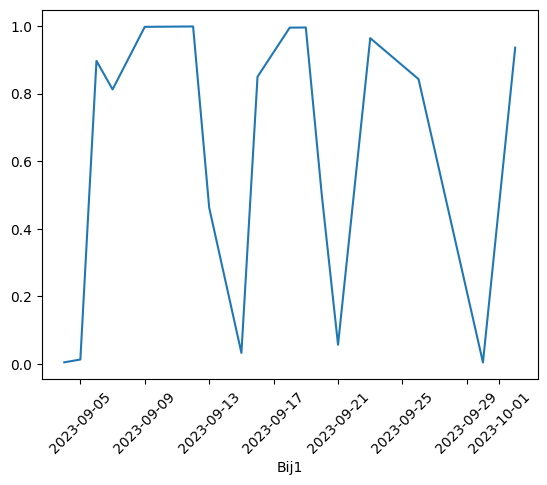

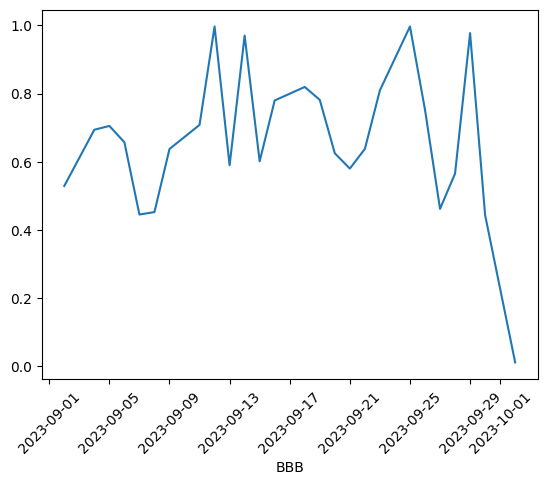

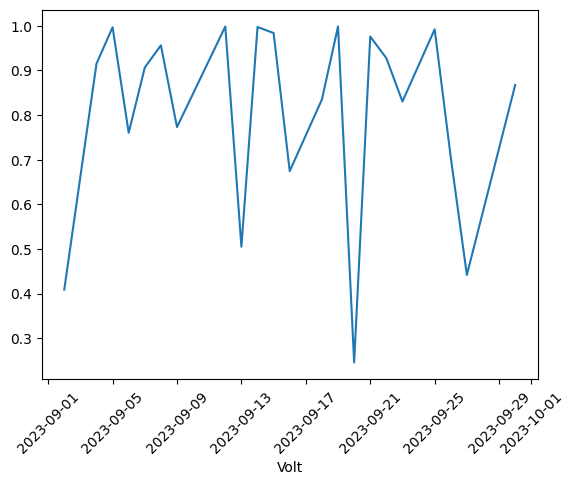

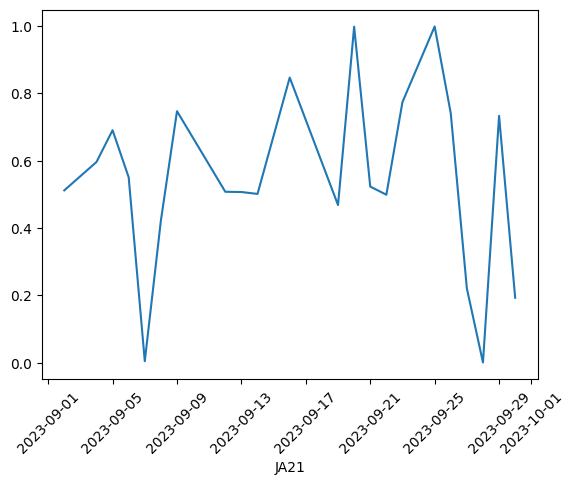

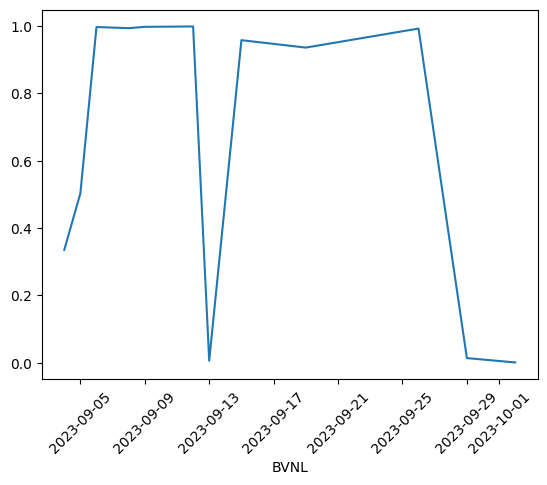

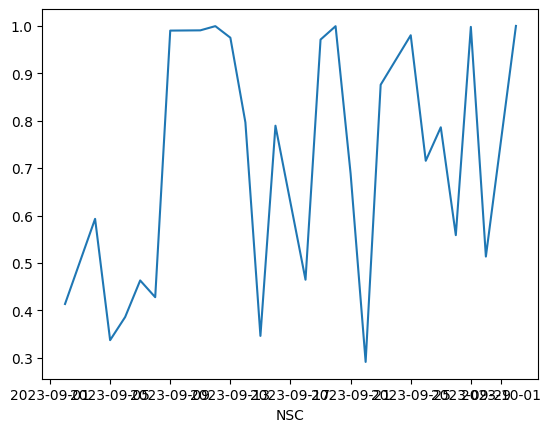

In [395]:
for idx, party in enumerate(parties):
    plt.xticks(rotation=45)
    plt.figure(idx+1)
    plt.plot(pdf[party]['standardized scores'])
    plt.xlabel(party)

plt.show()

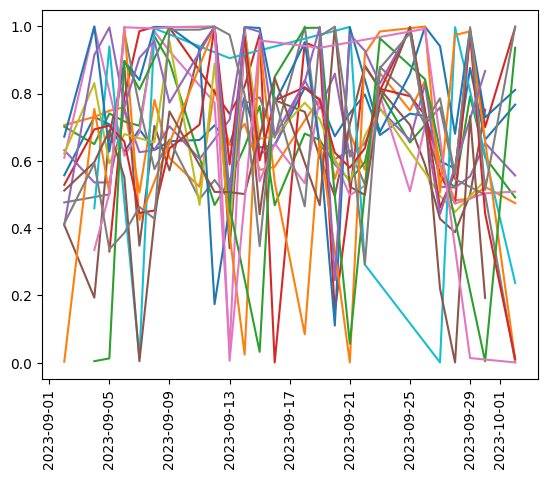

In [381]:
for party in parties:
    plt.plot(pdf[party]['standardized scores'])

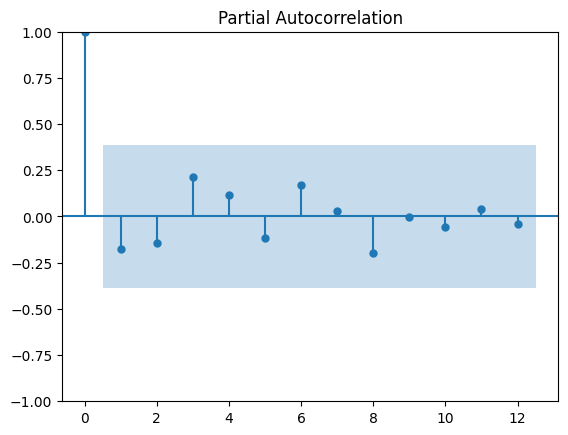

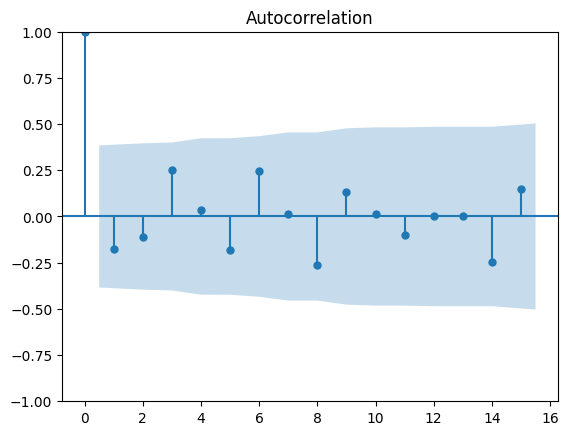

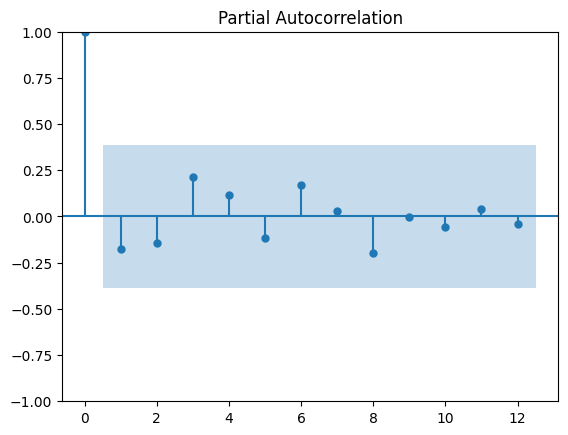

In [433]:
plot_acf(pdf['VVD']['standardized scores'])
plot_pacf(pdf['VVD']['standardized scores'], lags=12)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


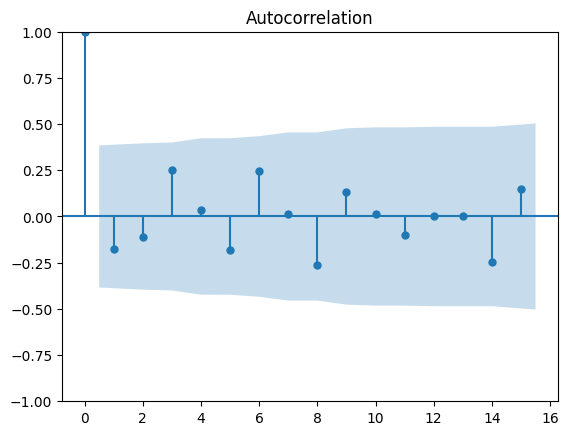

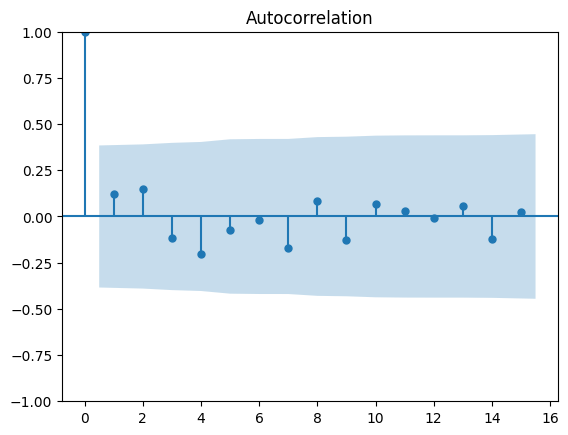

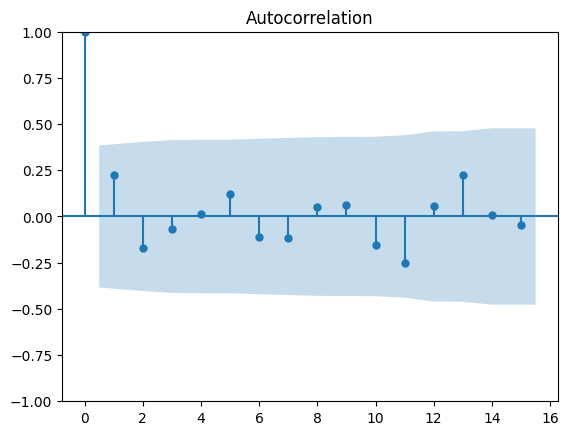

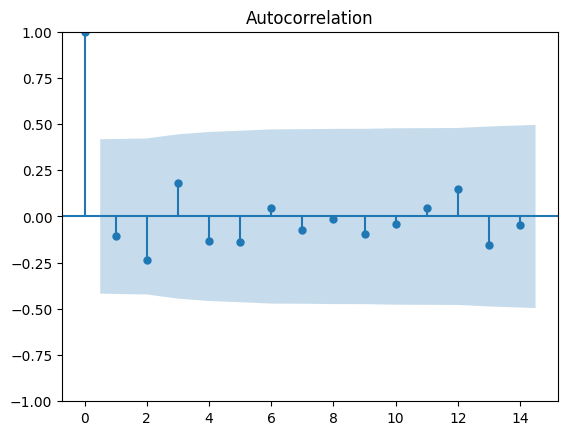

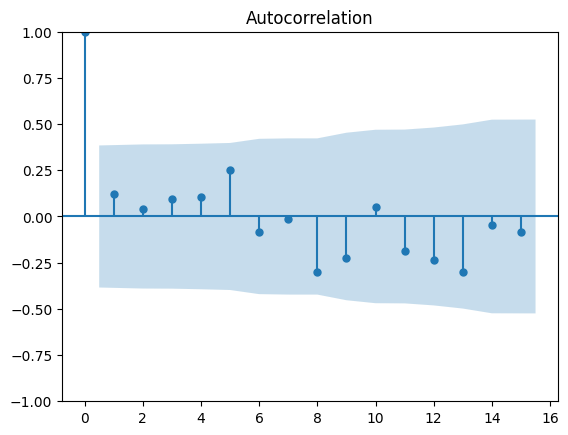

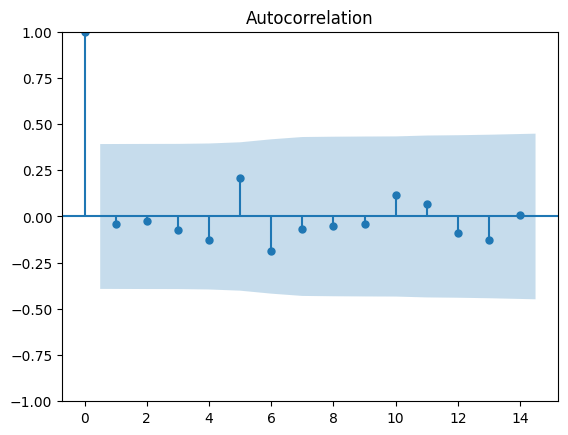

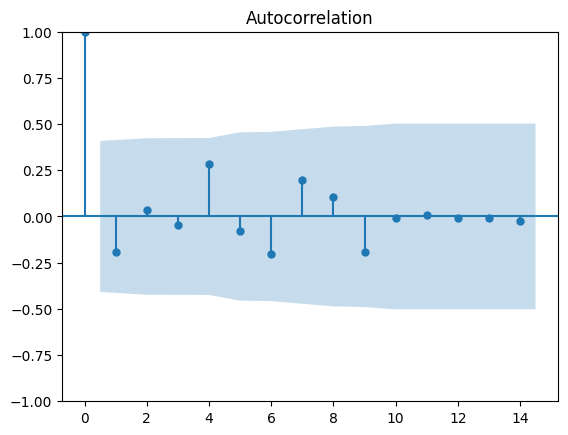

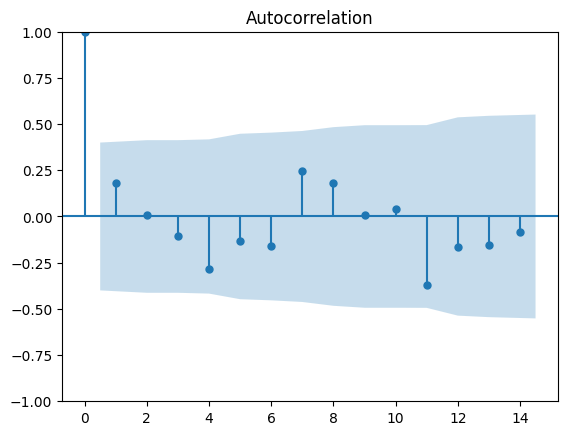

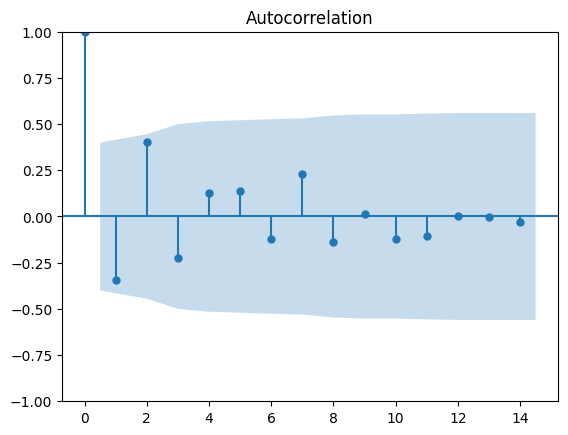

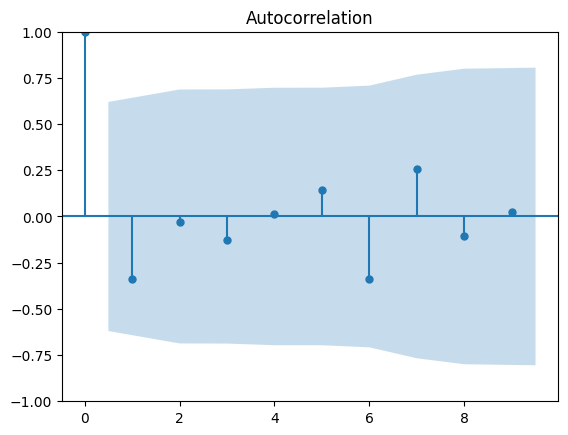

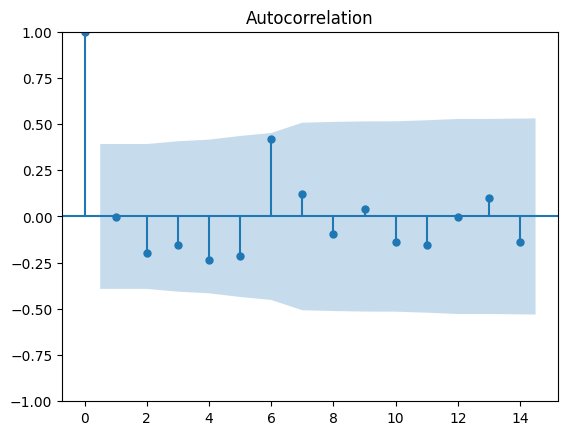

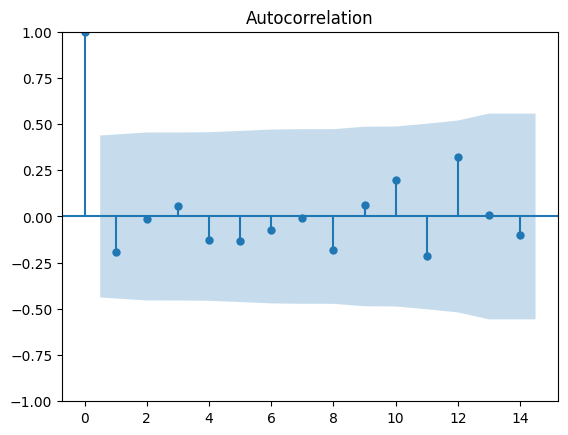

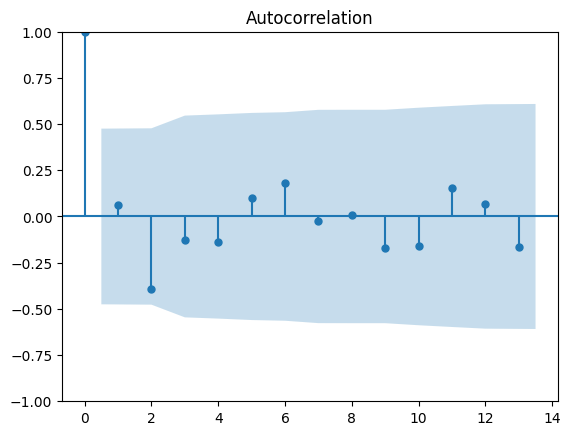

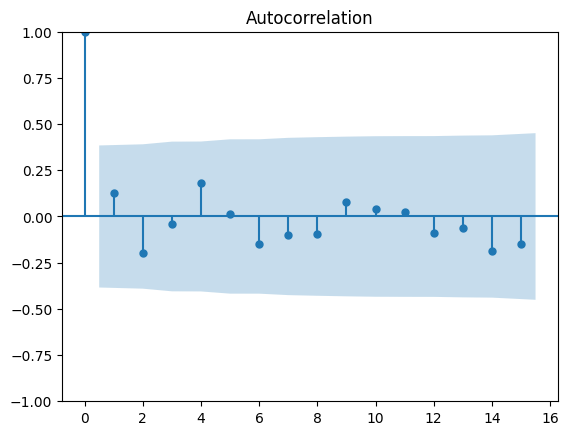

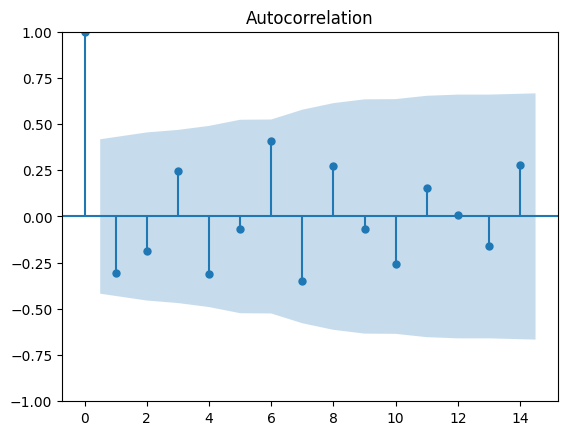

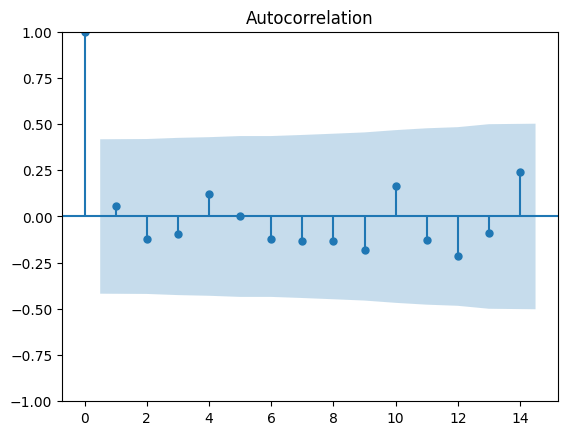

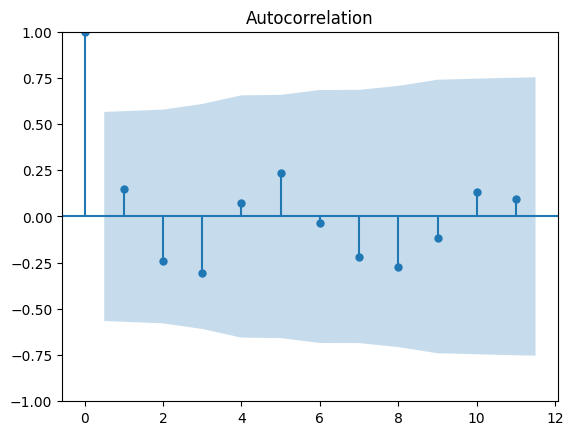

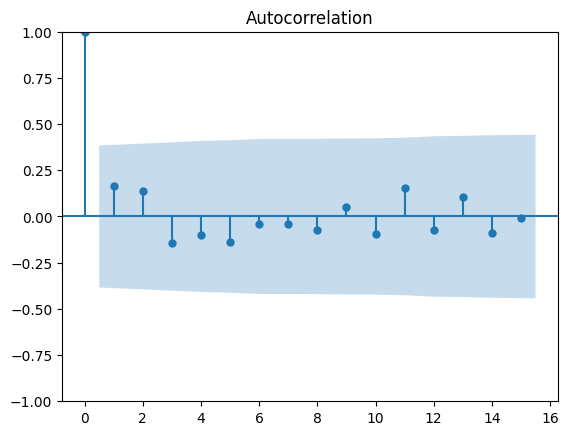

In [382]:
for idx, party in enumerate(parties):
    plot_acf(pdf[party]['standardized scores'])
    print(idx)

                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  18.771
Date:                  zo, 08 okt 2023   AIC                            -35.542
Time:                         13:49:36   BIC                            -34.323
Sample:                              0   HQIC                           -35.204
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0130      0.004      3.710      0.000       0.006       0.020
Ljung-Box (L1) (Q):                   6.26   Jarque-Bera (JB):                 0.62
Prob(Q):                              0

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


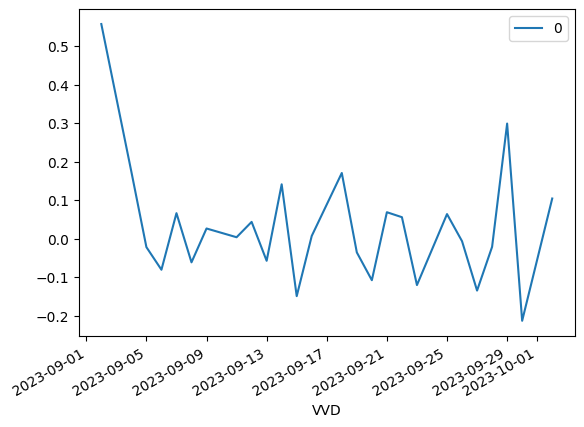

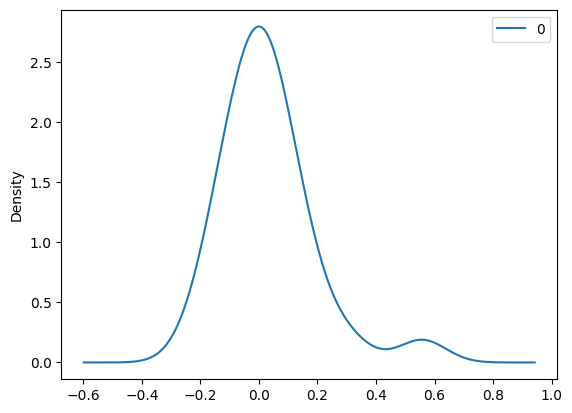

               0
count  26.000000
mean    0.029510
std     0.156693
min    -0.213263
25%    -0.060572
50%     0.005263
75%     0.067931
max     0.557134
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  11.102
Date:                  zo, 08 okt 2023   AIC                            -20.203
Time:                         13:49:36   BIC                            -18.985
Sample:                              0   HQIC                           -19.865
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0241      0.008      2.902      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


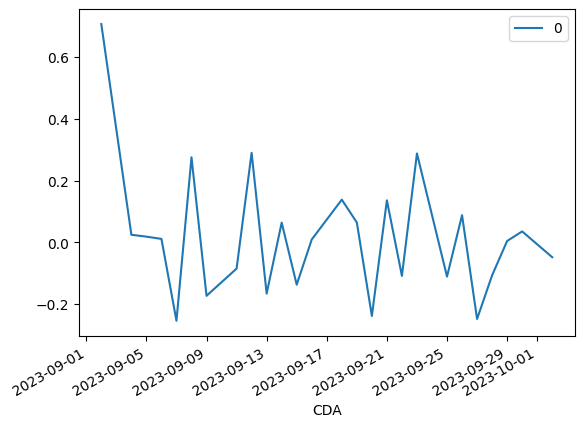

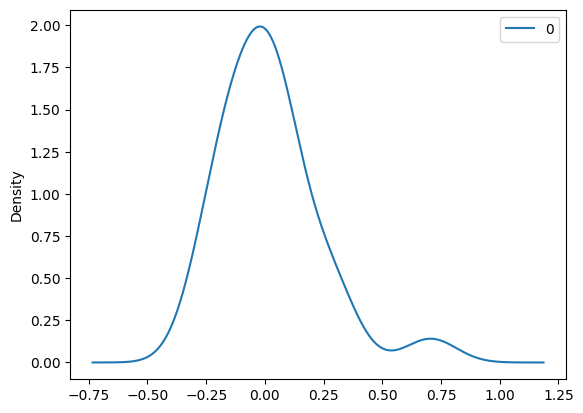

               0
count  26.000000
mean    0.018246
std     0.209040
min    -0.253829
25%    -0.110356
50%     0.010052
75%     0.081911
max     0.706314
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  11.679
Date:                  zo, 08 okt 2023   AIC                            -21.358
Time:                         13:49:37   BIC                            -20.139
Sample:                              0   HQIC                           -21.019
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0230      0.008      2.947      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


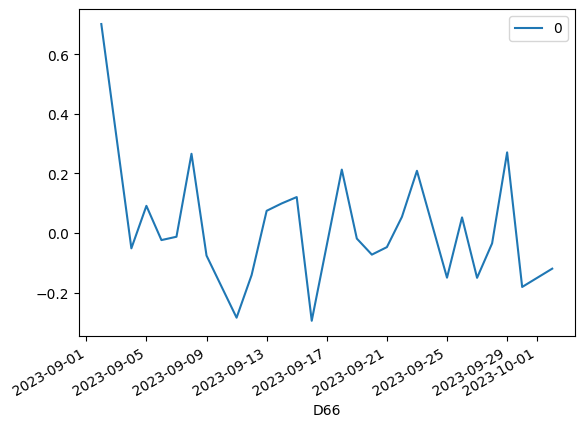

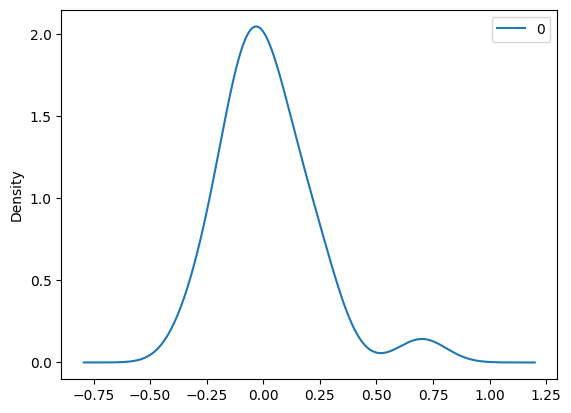

               0
count  26.000000
mean    0.018888
std     0.205712
min    -0.294739
25%    -0.108829
50%    -0.021320
75%     0.097166
max     0.701541
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   22
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 -11.170
Date:                  zo, 08 okt 2023   AIC                             24.339
Time:                         13:49:37   BIC                             25.384
Sample:                              0   HQIC                            24.566
                                  - 22                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1696      0.045      3.805      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

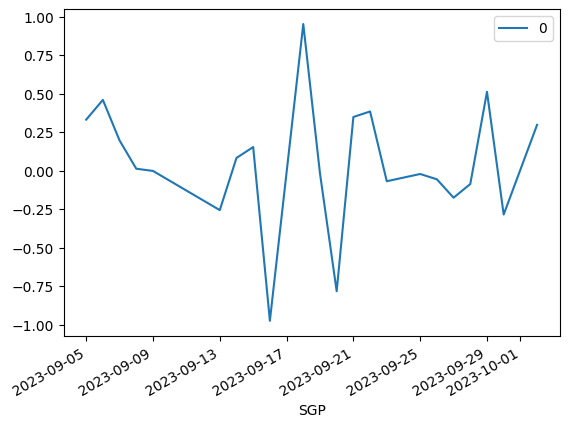

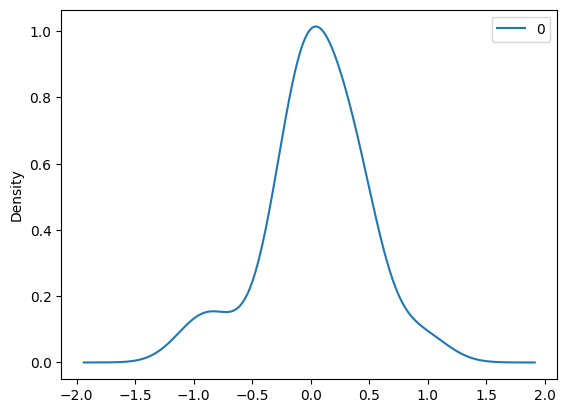

               0
count  22.000000
mean    0.045338
std     0.415569
min    -0.974729
25%    -0.082470
50%     0.005224
75%     0.322545
max     0.951758
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  11.407
Date:                  zo, 08 okt 2023   AIC                            -20.814
Time:                         13:49:37   BIC                            -19.595
Sample:                              0   HQIC                           -20.476
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0235      0.006      3.645      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


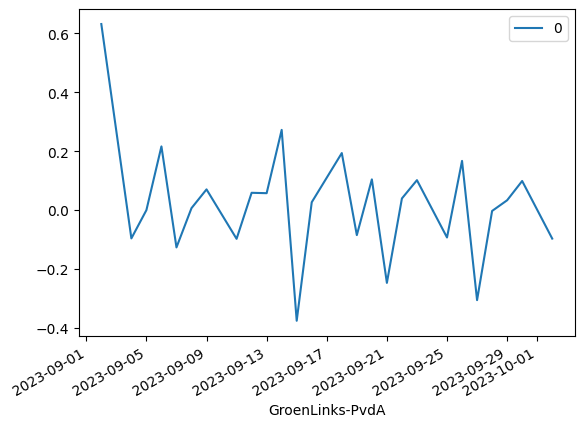

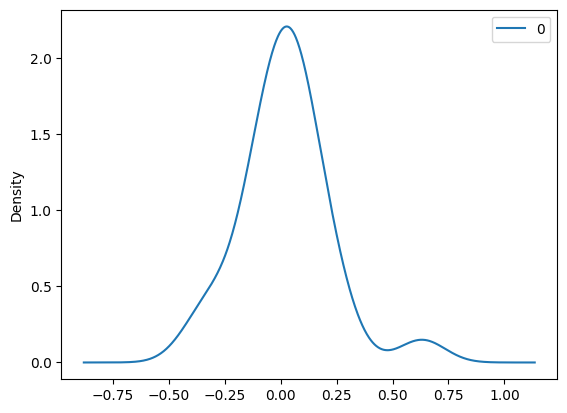

               0
count  26.000000
mean    0.021404
std     0.197466
min    -0.375422
25%    -0.095105
50%     0.030214
75%     0.101059
max     0.631705
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   25
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -5.892
Date:                  zo, 08 okt 2023   AIC                             13.784
Time:                         13:49:38   BIC                             14.962
Sample:                              0   HQIC                            14.096
                                  - 25                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0957      0.030      3.145      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


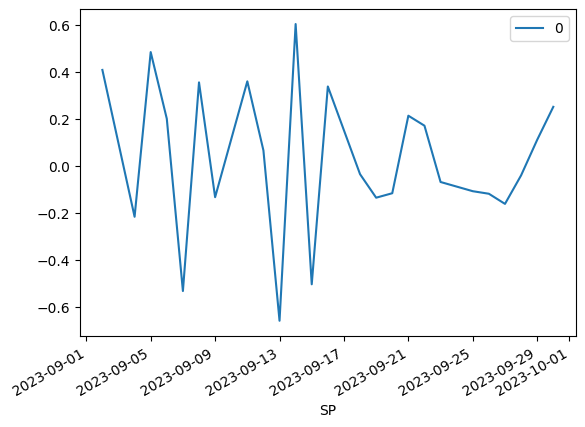

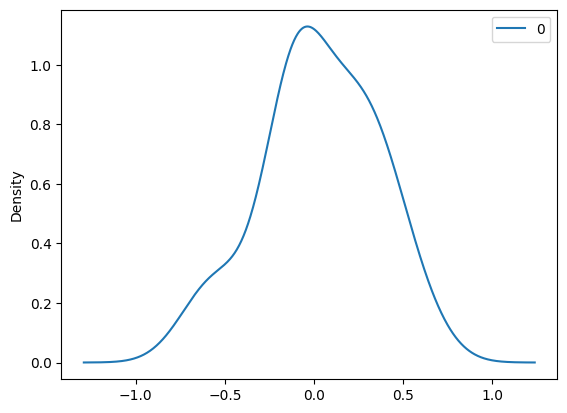

               0
count  25.000000
mean    0.030081
std     0.318917
min    -0.658926
25%    -0.132607
50%    -0.034628
75%     0.252239
max     0.604899
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   23
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -6.941
Date:                  zo, 08 okt 2023   AIC                             15.882
Time:                         13:49:38   BIC                             16.973
Sample:                              0   HQIC                            16.139
                                  - 23                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1100      0.025      4.437      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


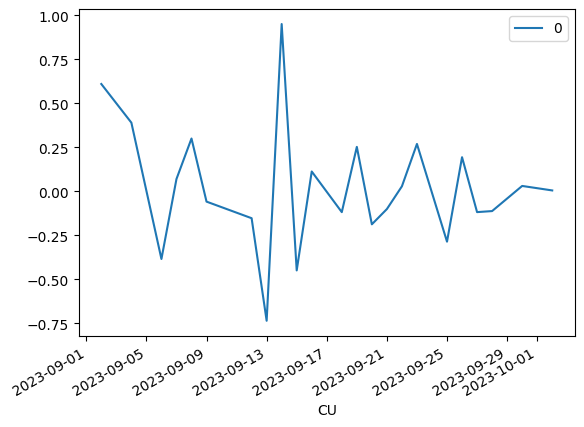

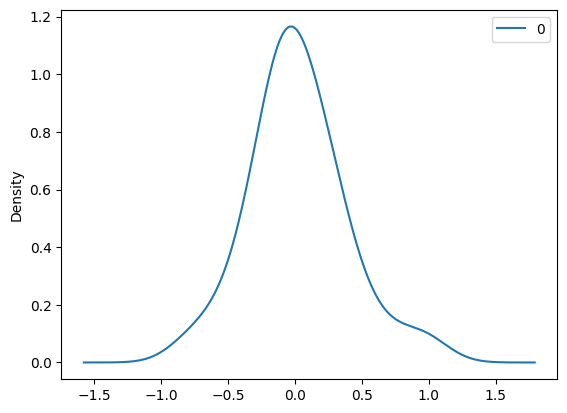

               0
count  23.000000
mean    0.022116
std     0.355543
min    -0.735012
25%    -0.135444
50%     0.005036
75%     0.223048
max     0.949923
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   24
Model:                  ARIMA(0, 1, 0)   Log Likelihood                   1.908
Date:                  zo, 08 okt 2023   AIC                             -1.816
Time:                         13:49:38   BIC                             -0.680
Sample:                              0   HQIC                            -1.530
                                  - 24                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0496      0.015      3.416      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


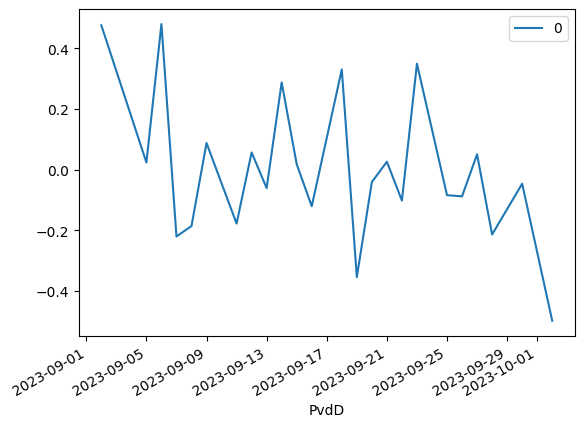

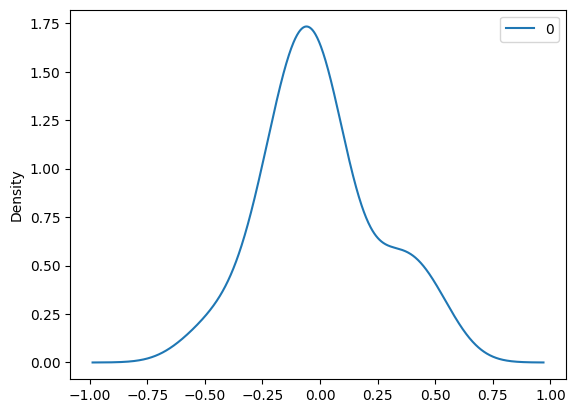

               0
count  24.000000
mean    0.000062
std     0.243868
min    -0.497904
25%    -0.134543
50%    -0.043266
75%     0.064890
max     0.480510
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   24
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -0.669
Date:                  zo, 08 okt 2023   AIC                              3.337
Time:                         13:49:39   BIC                              4.473
Sample:                              0   HQIC                             3.623
                                  - 24                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0621      0.016      3.782      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


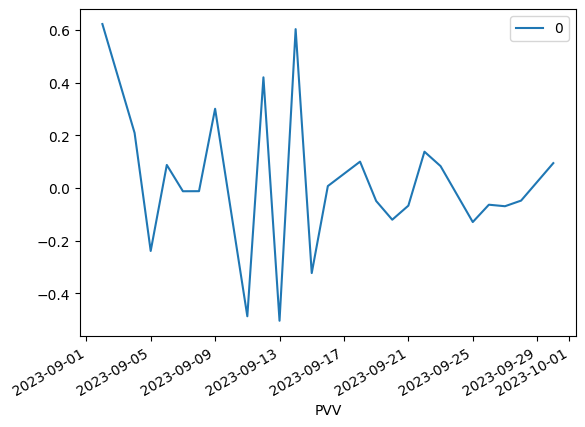

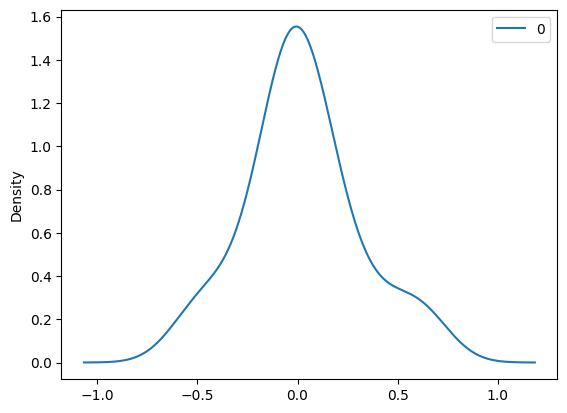

               0
count  24.000000
mean    0.022609
std     0.279904
min    -0.503645
25%    -0.081912
50%    -0.012174
75%     0.109469
max     0.622079
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   10
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -9.358
Date:                  zo, 08 okt 2023   AIC                             20.717
Time:                         13:49:39   BIC                             20.914
Sample:                              0   HQIC                            20.291
                                  - 10                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4685      0.384      1.219      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


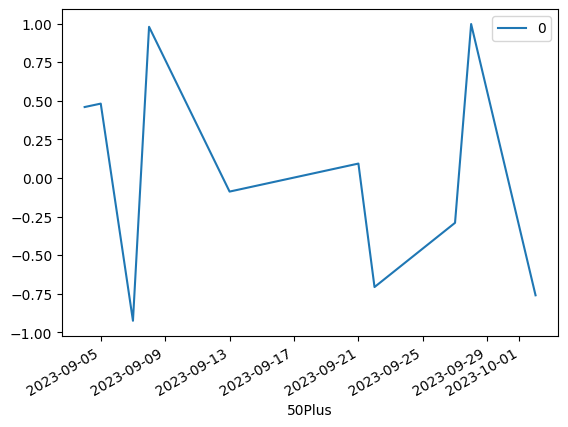

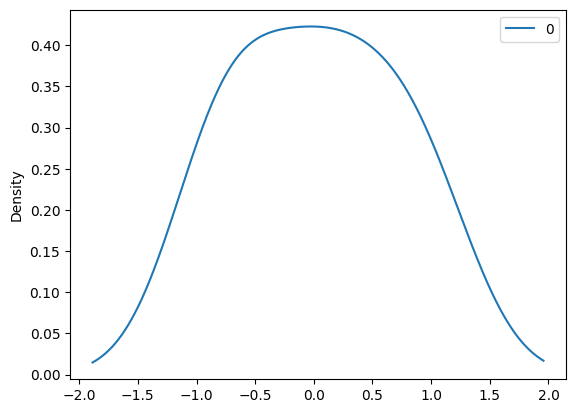

               0
count  10.000000
mean    0.023734
std     0.700907
min    -0.925024
25%    -0.602737
50%     0.002225
75%     0.475672
max     0.996588
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   25
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -8.843
Date:                  zo, 08 okt 2023   AIC                             19.686
Time:                         13:49:39   BIC                             20.865
Sample:                              0   HQIC                            19.999
                                  - 25                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1223      0.033      3.746      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

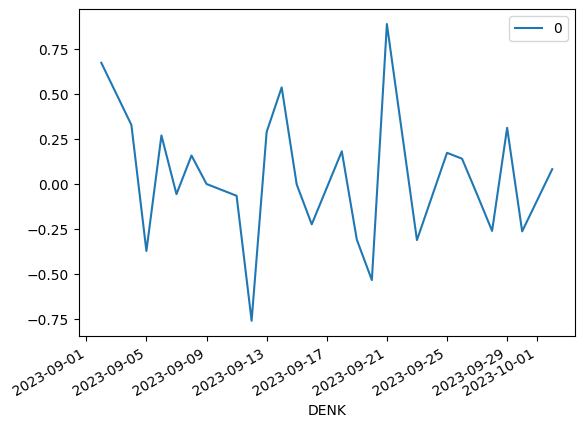

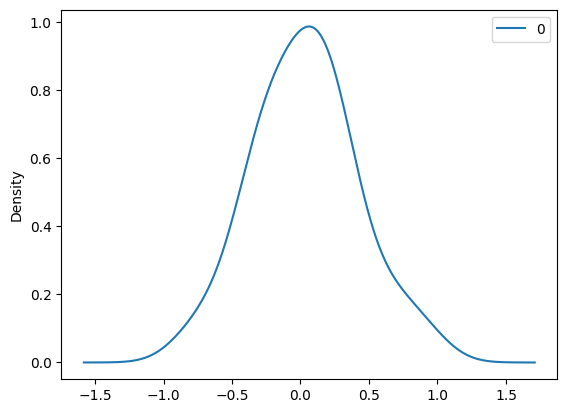

               0
count  25.000000
mean    0.032448
std     0.374241
min    -0.758797
25%    -0.260529
50%    -0.000076
75%     0.269226
max     0.887083
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   20
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 -16.513
Date:                  zo, 08 okt 2023   AIC                             35.026
Time:                         13:49:40   BIC                             35.970
Sample:                              0   HQIC                            35.185
                                  - 20                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3330      0.180      1.851      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


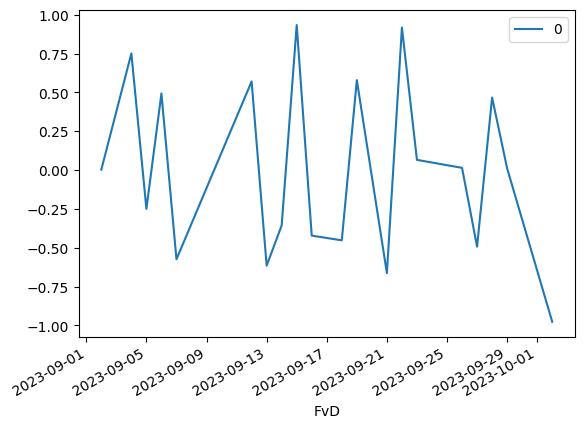

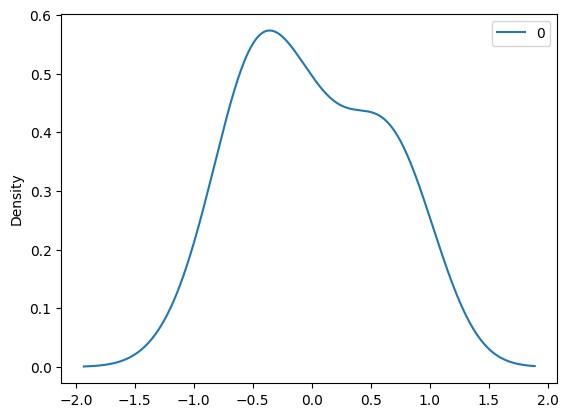

               0
count  20.000000
mean    0.000433
std     0.577040
min    -0.976619
25%    -0.462386
50%     0.007050
75%     0.512837
max     0.934407
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   17
Model:                  ARIMA(0, 1, 0)   Log Likelihood                 -13.139
Date:                  zo, 08 okt 2023   AIC                             28.278
Time:                         13:49:40   BIC                             29.051
Sample:                              0   HQIC                            28.318
                                  - 17                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3026      0.139      2.181      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


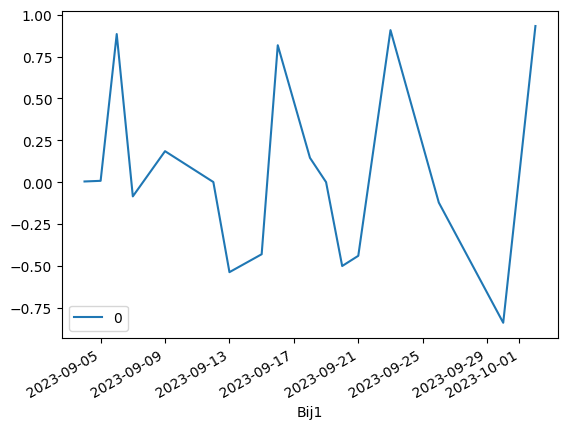

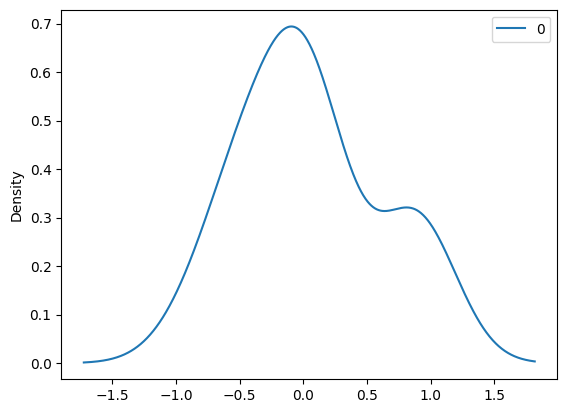

               0
count  17.000000
mean    0.055076
std     0.547119
min    -0.838835
25%    -0.429881
50%     0.001131
75%     0.185277
max     0.932222
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -0.858
Date:                  zo, 08 okt 2023   AIC                              3.717
Time:                         13:49:40   BIC                              4.936
Sample:                              0   HQIC                             4.055
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0627      0.021      2.967      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


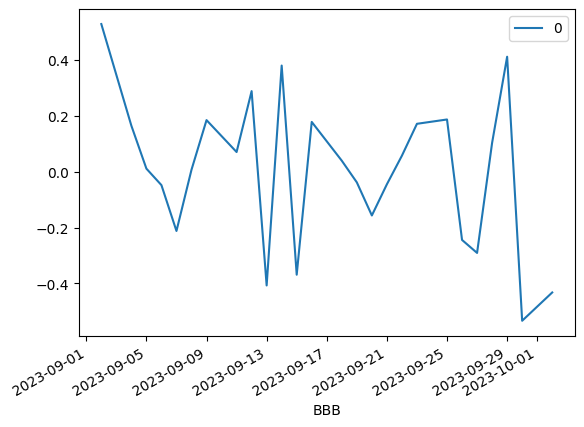

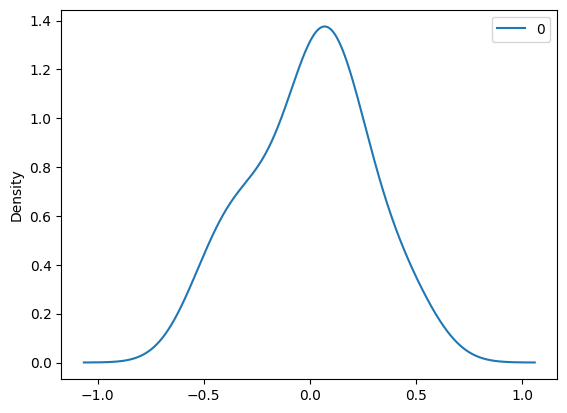

               0
count  26.000000
mean    0.000443
std     0.271847
min    -0.533408
25%    -0.198069
50%     0.025376
75%     0.176745
max     0.528887
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   22
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -7.593
Date:                  zo, 08 okt 2023   AIC                             17.186
Time:                         13:49:41   BIC                             18.231
Sample:                              0   HQIC                            17.413
                                  - 22                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1207      0.039      3.067      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


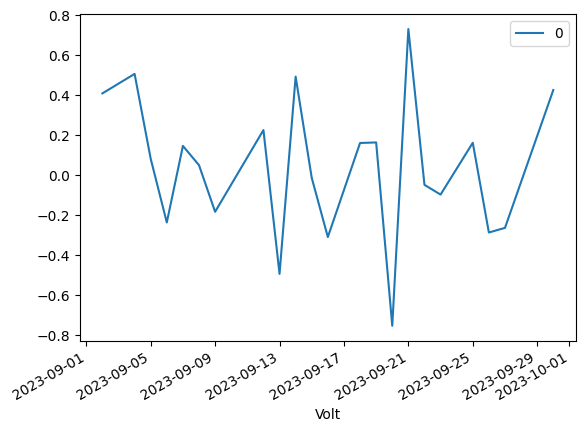

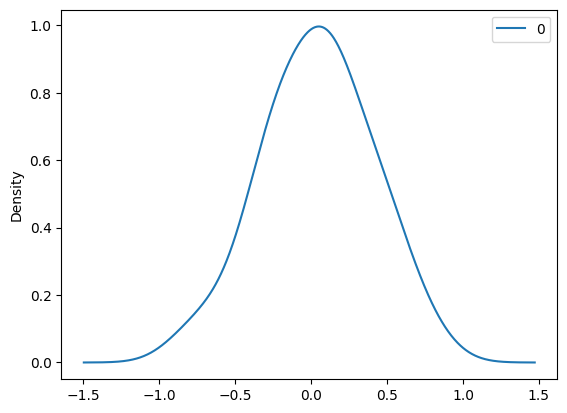

               0
count  22.000000
mean    0.039426
std     0.356363
min    -0.753134
25%    -0.223234
50%     0.065919
75%     0.209961
max     0.730555
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   22
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -8.573
Date:                  zo, 08 okt 2023   AIC                             19.145
Time:                         13:49:41   BIC                             20.190
Sample:                              0   HQIC                            19.372
                                  - 22                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1325      0.056      2.364      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


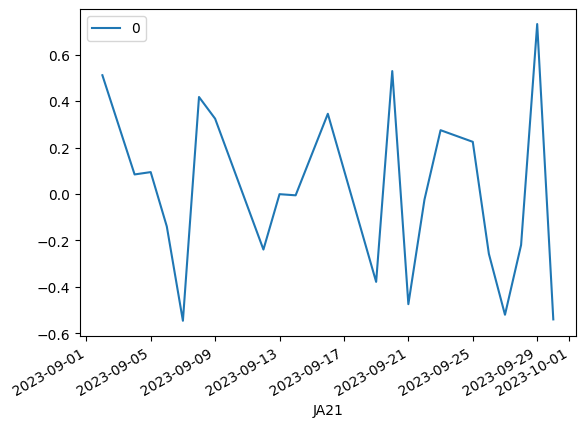

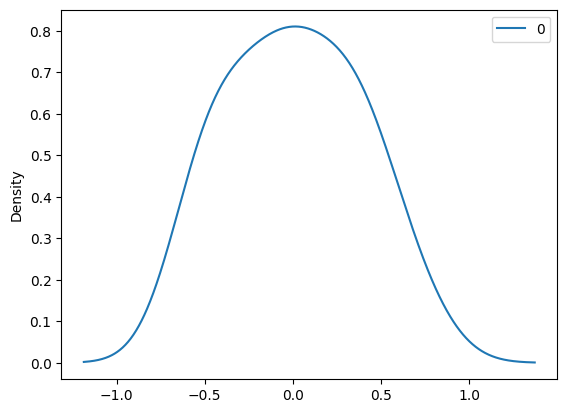

               0
count  22.000000
mean    0.008764
std     0.380607
min    -0.546320
25%    -0.253292
50%    -0.003204
75%     0.312245
max     0.732528
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   12
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -8.691
Date:                  zo, 08 okt 2023   AIC                             19.383
Time:                         13:49:42   BIC                             19.781
Sample:                              0   HQIC                            19.132
                                  - 12                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2843      0.118      2.414      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


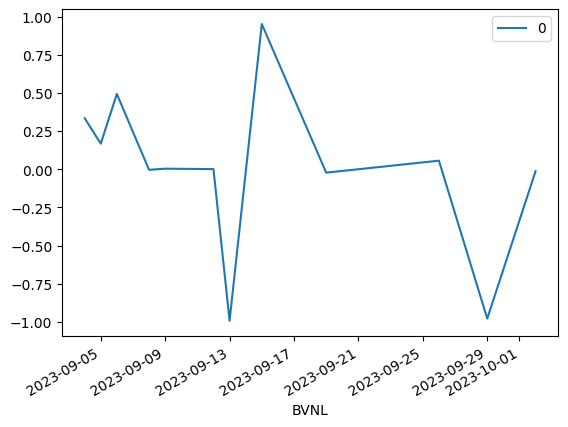

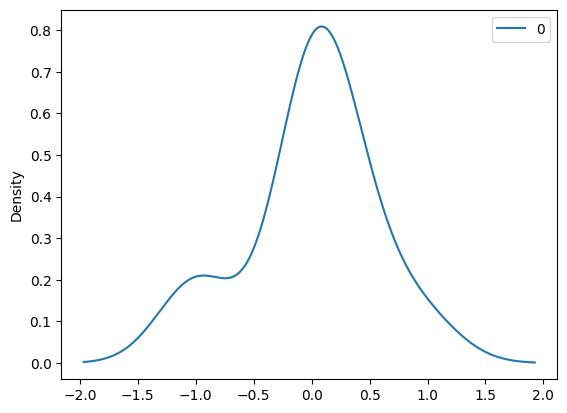

               0
count  12.000000
mean    0.000062
std     0.542719
min    -0.993065
25%    -0.015235
50%     0.002554
75%     0.209864
max     0.952301
                                SARIMAX Results                                
Dep. Variable:     standardized scores   No. Observations:                   26
Model:                  ARIMA(0, 1, 0)   Log Likelihood                  -7.237
Date:                  zo, 08 okt 2023   AIC                             16.474
Time:                         13:49:42   BIC                             17.693
Sample:                              0   HQIC                            16.812
                                  - 26                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1045      0.040      2.601      

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


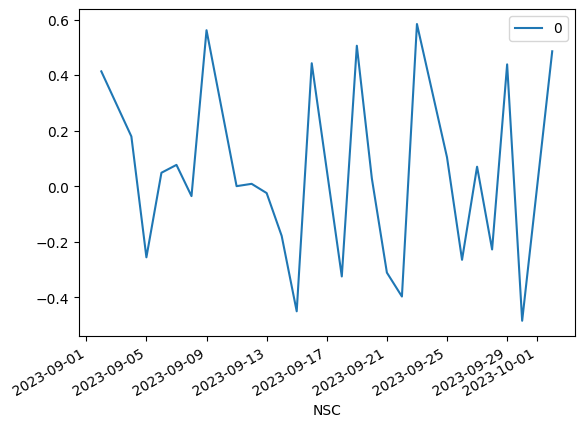

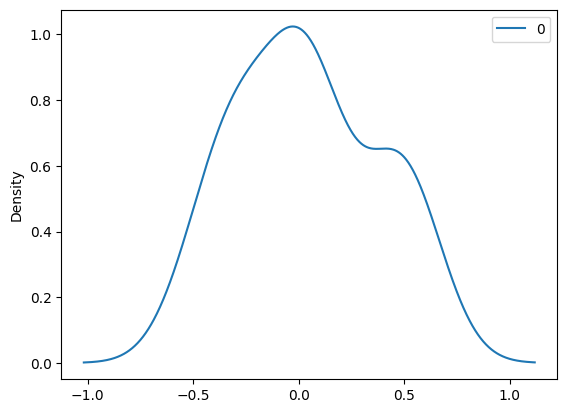

               0
count  26.000000
mean    0.038446
std     0.331316
min    -0.483986
25%    -0.248528
50%     0.018557
75%     0.355102
max     0.584056


In [434]:
# fit an ARIMA model and plot residual errors

for party in parties:
    model = ARIMA(pdf[party]['standardized scores'], order=(0,1,0))
    model_fit = model.fit()
    # summary of fit model
    print(model_fit.summary())
    # line plot of residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.xlabel(party)
    plt.show()
    # density plot of residuals
    residuals.plot(kind='kde')
    plt.show()
    # summary stats of residuals
    print(residuals.describe())


In [415]:
pdf['VVD'][:int(len(pdf['VVD'] + 1)*.80)]

,standardized scores,count
Date,,
2023-09-02,0.557134,28
2023-09-04,0.730696,19
2023-09-05,0.708616,18
2023-09-06,0.627831,19
2023-09-07,0.693901,22
2023-09-08,0.632326,23
2023-09-09,0.658621,29
2023-09-11,0.662216,6
2023-09-12,0.705635,13


In [425]:
model_data = {}

for party in parties:
    model_data[party] = {}
    model_data[party]['train_data'] = pdf[party][:int((len(pdf[party])+1)*.80)]
    model_data[party]['test_data'] = pdf[party][int((len(pdf[party])+1)*.80):]

predicted=0.694602, expected=0.598942
predicted=0.714250, expected=0.577637
predicted=0.682079, expected=0.876382
predicted=0.671871, expected=0.663119
predicted=0.586061, expected=0.767258
Test RMSE: 0.140


/var/folders/9z/gq738z712wv0tz09r4b4vw6c0000gn/T/ipykernel_2027/850251599.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


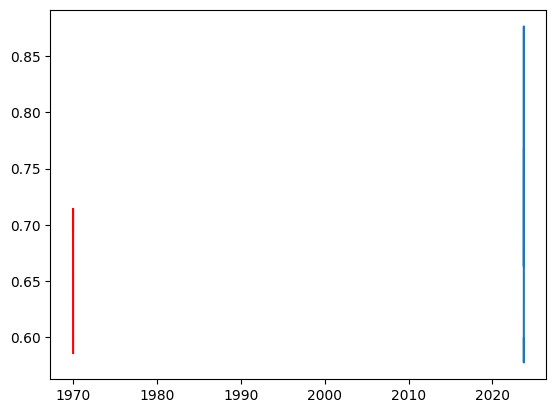

In [427]:
# evaluate an ARIMA model using a walk-forward validation

# split into train and test sets
test = model_data['VVD']['test_data']['standardized scores']
history = [x for x in model_data['VVD']['train_data']['standardized scores']]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/niels/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
 

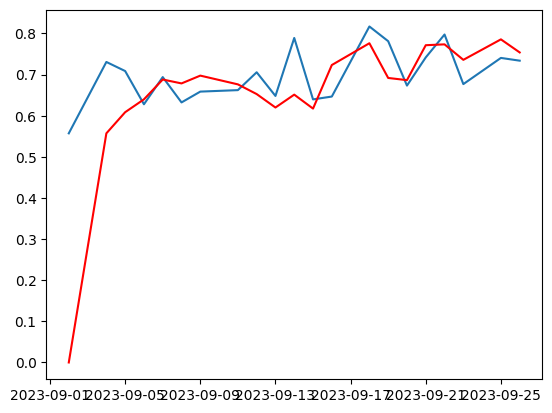

In [446]:
model = ARIMA(model_data['VVD']['train_data']['standardized scores'], order=(0,1,2))
results = model.fit()
plt.plot(model_data['VVD']['train_data']['standardized scores'])
plt.plot(results.fittedvalues, color='red')

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [444]:
results.plot_predict(1,30)


AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'